In [7]:
# Imports
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit_aer.noise import (
    NoiseModel,
    pauli_error
)
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


In [3]:
# Building the circuit
qc = QuantumCircuit(4)
qc.h(0)
for q in range(3):
    qc.cx(q, q+1)
qc.measure_all()
qc.draw()

┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3

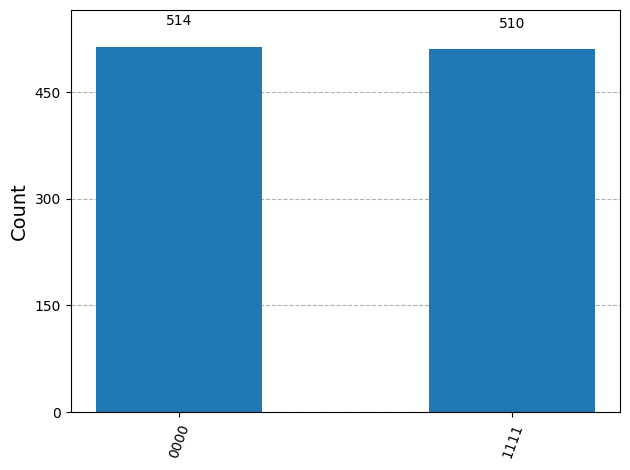

In [4]:
# ideal simuluation
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(qc).result()
plot_histogram(result_ideal.get_counts(0))

In [5]:
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# Quantum errors
error_reset = pauli_error([("X", p_reset), ("I", 1-p_reset)])
error_meas = pauli_error([("X", p_meas), ("I", 1-p_meas)])
error_gate1 = pauli_error([("X", p_gate1), ("I", 1-p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'u3', 'u1', 'cx', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


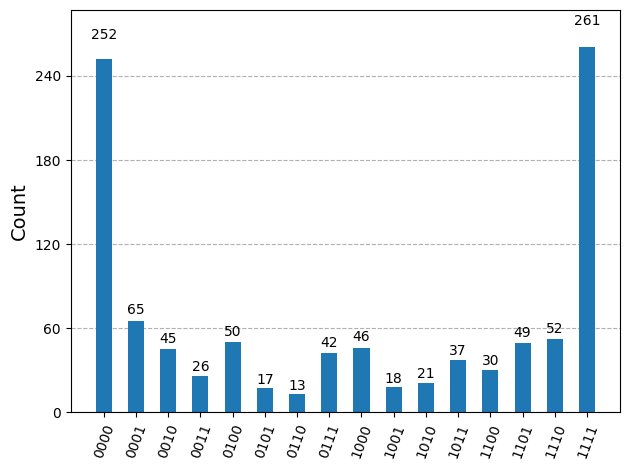

In [8]:
sim_noise = AerSimulator(noise_model=noise_bit_flip)

passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_noise
)
c_noise = passmanager.run(qc)

result_bit_flip = sim_noise.run(c_noise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

plot_histogram(counts_bit_flip)